In [1]:
import pandas as pd
import qiime2 as q2
import numpy as np
import scipy.stats as ss
import biom
import skbio

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from qiime2.plugins import greengenes2
from itertools import combinations
#from qiime2.plugins import gemelli, greengenes2, emperor, diversity
#import upsetplot

In [2]:
gg2_tax = pd.read_csv('../Updated_Data/gg2_taxonomy_16s.csv', index_col='Feature ID')
tax_dict = gg2_tax['Taxon'].to_dict()

def read_results(p):
    return pd.read_csv(p, sep='\t', index_col='Feature', dtype={'Feature': 'str'})

def get_taxonomy(s):
    split = s.split(';')
    total_length = len(split) - 1
    while (total_length > 0) & (len(split[total_length]) == 4): 
        total_length -= 1
    return split[total_length]

def unpack_hdi_and_filter(df, col, lower, upper):
    df[['lower', 'upper']] = df[col].str.split(',', expand=True)
    # remove ( from lower and ) from upper and convert to float 
    df['lower'] = df['lower'].str[1:].astype('float')
    df['upper'] = df['upper'].str[:-1].astype('float')
    df['significant'] = np.where((df.lower > 0) | (df.upper < 0), 'yes', 'no')
    df['direction'] = np.where((df['significant'] == 'yes') & (df['lower'] < 0), lower, 
                                np.where((df['significant'] == 'yes') & (df['upper'] > 0), upper, np.nan))
    df['lower'] = df[col.replace('hdi', 'mean')] - df['lower'] 
    df['upper'] = df['upper'] - df[col.replace('hdi', 'mean')]
    df['full_taxonomy'] = [tax_dict[i] for i in df.index]
    df['taxonomy'] = [get_taxonomy(i) for i in df.full_taxonomy]
    df['taxonomy'] = np.where(df['taxonomy'].str.startswith('s__'), df['taxonomy'].str[3:], df['taxonomy'])
    #only_sigs = df.loc[df['significant'] == 'yes']
    return df

In [3]:
dir_with_results = '../Updated_Results/medications-final/'
key = {
    'Group_Anxiety': ['anxiety.beta_var.tsv', 'DX_ANX[T.True]_', 'HC', 'ANX'], 
    'Group_Depression': ['depression.beta_var.tsv', 'DX_MDD[T.True]_', 'HC', 'MDD'], 
    'Medications_Anxiety': ['anxiolytics.beta_var.tsv', 'N05B_Anxiolytics[T.True]_', 'Unmedicated ANX', 
                            'Anxiolytics'],
    'Medications_Depression': ['antidepressants.beta_var.tsv', 'N06A_Antidepressants[T.True]_', 'Unmedicated MDD', 
                               'Antidepressants'], 
}

all_results = {}

for k in key: 
    all_results[k] = unpack_hdi_and_filter(read_results(dir_with_results + key[k][0]), 
                                           key[k][1]+'hdi', key[k][2], key[k][3])

In [4]:
anx_enriched = all_results['Group_Anxiety'].loc[all_results['Group_Anxiety']['direction'] == 'ANX']
anx_hc = all_results['Group_Anxiety'].loc[all_results['Group_Anxiety']['direction'] == 'HC']
mdd_enriched = all_results['Group_Depression'].loc[all_results['Group_Depression']['direction'] == 'MDD']
mdd_hc = all_results['Group_Depression'].loc[all_results['Group_Depression']['direction'] == 'HC']

mdd_and_anx = mdd_enriched.index.intersection(anx_enriched.index)
hc_common = anx_hc.index.intersection(mdd_hc.index)

In [5]:
anx_enriched.to_csv('../Updated_Results/birdman_sig_plots/anxiety_enriched.csv')
anx_hc.to_csv('../Updated_Results/birdman_sig_plots/anx_hc_enriched.csv')

mdd_enriched.to_csv('../Updated_Results/birdman_sig_plots/depression_enriched.csv')
mdd_hc.to_csv('../Updated_Results/birdman_sig_plots/mdd_hc_enriched.csv')

In [7]:
transfer_df = pd.read_csv('../Updated_Data/asv_to_metag.tsv', sep='\t', names=['asv', 'gotu', 'distance'], 
                         index_col=0)
transfer_dict = transfer_df['gotu'].to_dict()

def get_metag_transfer(list_of_enriched): 
    return np.unique([transfer_dict[i] for i in list_of_enriched])

full_table_df = q2.Artifact.load('../Updated_Data/final_tables/full_table.qza').view(pd.DataFrame)
full_metadata = pd.read_csv('../Updated_Data/final_tables/metadata_full.tsv', sep='\t', index_col=0)
gg2_tree = q2.Artifact.load('../Updated_Data/2022.10.phylogeny.asv.nwk.qza')

metag_table = q2.Artifact.load('../Updated_Data/Medications_Data/metag_table_t2t.qza')
metag_table = greengenes2.methods.filter_features(feature_table=metag_table, 
                                                  reference=gg2_tree).filtered_feature_table.view(pd.DataFrame)
common_samples_16s_metag = metag_table.index.intersection(full_table_df.index)
metag_table_common = metag_table.loc[common_samples_16s_metag]
metag_md = pd.read_csv('../Updated_Data/Medications_Data/metag_md.tsv', sep='\t', index_col=0)
metag_transfer_16s = metag_table[metag_table.columns.intersection(get_metag_transfer(full_table_df.columns))]

In [8]:
common_16s = full_table_df.loc[common_samples_16s_metag]
common_16s.index = [i + '.16s' for i in common_16s.index]
common_metag = metag_transfer_16s.loc[common_samples_16s_metag]
common_metag.index = [i + '.wgs' for i in common_metag.index]
combined_table = pd.concat([common_16s, common_metag])
combined_table.fillna(0, inplace=True)

md_16s = metag_md.loc[common_samples_16s_metag]
md_metag = md_16s.copy()
md_16s.index = [i + '.16s' for i in md_16s.index]
md_16s['datatype'] = '16S'
md_metag.index = [i + '.wgs' for i in md_metag.index]
md_metag['datatype'] = 'WGS'
combined_md = pd.concat([md_16s, md_metag])
combined_table_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', combined_table)
combined_md_q2 = q2.Metadata(combined_md.rename_axis(index='SampleID')[['datatype']])

In [9]:
table_16s = full_table_df.copy()
table_16s.index = [i + '.16s' for i in table_16s.index]
table_metag = metag_table.copy()
table_metag.index = [i + '.wgs' for i in table_metag.index]
combined_full_table = pd.concat([table_16s, table_metag]).fillna(0)

md_16s_full = full_metadata.copy()
md_16s_full.index = [i + '.16s' for i in md_16s_full.index]
md_16s_full['datatype'] = '16S'
md_metag_full = metag_md.copy()
md_metag_full.index = [i + '.wgs' for i in md_metag_full.index]
md_metag_full['datatype'] = 'WGS'
md_combined_full = pd.concat([md_16s_full, md_metag_full])
md_combined_full_q2 = q2.Metadata(md_combined_full.rename_axis('SampleID')[['datatype']])
combined_full_table_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', combined_full_table)

## Generate log ratios & Additional Categories

In [10]:
def create_log_ratio_column(x, top_microbes, bottom_microbes): 
    if (x[top_microbes].sum() == 0) | (x[bottom_microbes].sum() == 0): 
        return np.nan
    return np.log(x[top_microbes].sum() / x[bottom_microbes].sum())

full_metadata['gad_lr'] = full_table_df.apply(create_log_ratio_column, axis=1, 
                                              args=(anx_enriched.index, anx_hc.index))
full_metadata['mdd_lr'] = full_table_df.apply(create_log_ratio_column, axis=1, 
                                              args=(mdd_enriched.index, mdd_hc.index))
full_metadata['common_lr'] = full_table_df.apply(create_log_ratio_column, axis=1, 
                                                 args=(mdd_and_anx, hc_common))

full_metadata['gad_med_group'] = np.where((full_metadata['DX_HC']) & 
                                          (full_metadata['medication_group']=='Unmedicated'), 'Healthy Controls', 
                                          np.where((full_metadata['DX_ANX']) & 
                                                   (full_metadata['medication_group']=='Antidepressant/Antianxiety'), 
                                                   'Medicated ANX', 
                                                   np.where((full_metadata['DX_ANX']) & 
                                                            (full_metadata['medication_group']=='Unmedicated'), 
                                                             'Unmedicated ANX', 'nan')))
full_metadata['mdd_med_group'] = np.where((full_metadata['DX_HC']) & 
                                          (full_metadata['medication_group']=='Unmedicated'), 'Healthy Controls', 
                                          np.where((full_metadata['DX_MDD']) & 
                                                   (full_metadata['medication_group']=='Antidepressant/Antianxiety'), 
                                                   'Medicated MDD', 
                                                   np.where((full_metadata['DX_MDD']) & 
                                                            (full_metadata['medication_group']=='Unmedicated'), 
                                                             'Unmedicated MDD', 'nan')))
full_metadata['common_group'] = np.where((full_metadata['DX_HC']) & 
                                         (full_metadata['medication_group']=='Unmedicated'), 'Healthy Controls', 
                                         np.where((full_metadata['GroupAssignment'] == 'Mood/Anxiety') & 
                                                  (full_metadata['medication_group']=='Antidepressant/Antianxiety'), 
                                                   'Medicated Mood/Anxiety', 
                                                  np.where((full_metadata['GroupAssignment'] == 'Mood/Anxiety') & 
                                                           (full_metadata['medication_group']=='Unmedicated'), 
                                                           'Unmedicated Mood/Anxiety', 'nan')))
metadata_subset = full_metadata.loc[full_metadata.index.intersection(common_samples_16s_metag)]

In [11]:
metag_md['gad_lr']=metag_table_common.apply(create_log_ratio_column, axis=1, 
                                            args=(get_metag_transfer(anx_enriched.index), 
                                                  get_metag_transfer(anx_hc.index)))
metag_md['mdd_lr']=metag_table_common.apply(create_log_ratio_column, axis=1, 
                                            args=(get_metag_transfer(mdd_enriched.index), 
                                                  get_metag_transfer(mdd_hc.index)))

metag_md['gad_med_group'] = np.where((metag_md['DX_HC']) & (metag_md['medication_group']=='Unmedicated'), 
                                     'Healthy Controls', 
                                     np.where((metag_md['DX_ANX']) & 
                                              (metag_md['medication_group']=='Antidepressant/Antianxiety'), 
                                              'Medicated ANX', 
                                              np.where((metag_md['DX_ANX']) & 
                                                       (metag_md['medication_group']=='Unmedicated'), 
                                                       'Unmedicated ANX', 'nan')))
metag_md['mdd_med_group'] = np.where((metag_md['DX_HC']) & (metag_md['medication_group']=='Unmedicated'), 
                                     'Healthy Controls', 
                                     np.where((metag_md['DX_MDD']) & 
                                              (metag_md['medication_group']=='Antidepressant/Antianxiety'), 
                                              'Medicated MDD', 
                                              np.where((metag_md['DX_MDD']) & 
                                                       (metag_md['medication_group']=='Unmedicated'), 
                                                       'Unmedicated MDD', 'nan')))
metag_md['common_group'] = np.where((metag_md['DX_HC']) & (metag_md['medication_group']=='Unmedicated'), 
                                    'Healthy Controls', 
                                    np.where((metag_md['GroupAssignment'] == 'Mood/Anxiety') & 
                                             (metag_md['medication_group']=='Antidepressant/Antianxiety'), 
                                             'Medicated Mood/Anxiety', 
                                             np.where((metag_md['GroupAssignment'] == 'Mood/Anxiety') & 
                                                      (metag_md['medication_group']=='Unmedicated'), 
                                                      'Unmedicated Mood/Anxiety', 'nan')))

## Anxiety Figure

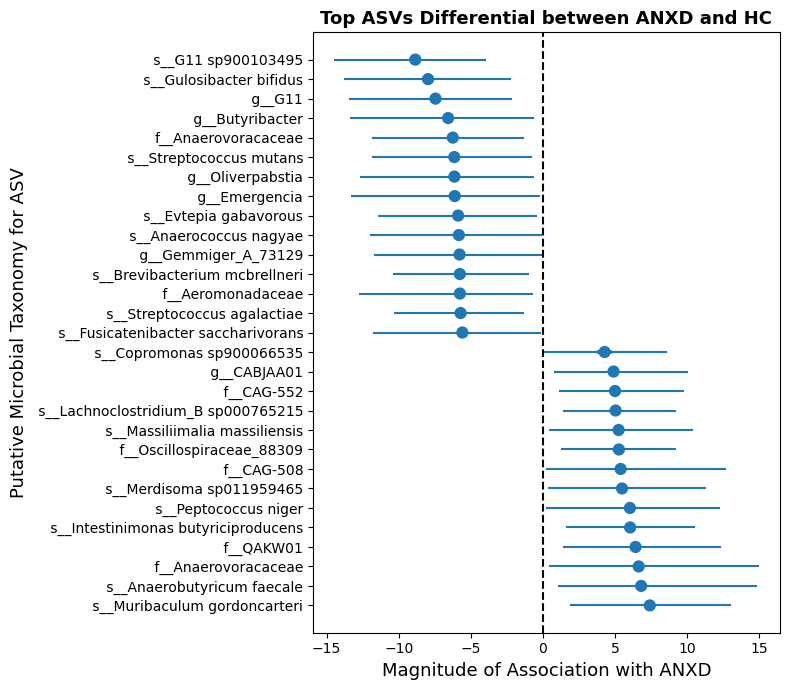

In [13]:
anx_for_plot = pd.concat([anx_hc, anx_enriched]).sort_values(by='DX_ANX[T.True]_mean')
# make distinct entries for f__Anaerovoracaceae
anx_for_plot['taxonomy'] = np.where((anx_for_plot['taxonomy'] == ' f__Anaerovoracaceae') & 
                                    (anx_for_plot['direction'] == 'HC'), 'f__Anaerovoracaceae', 
                                    anx_for_plot['taxonomy'])

anx_for_plot = pd.concat([anx_for_plot[:15], anx_for_plot[-15:]])
fig, ax = plt.subplots(figsize=(8, 7))
sns.pointplot(data=anx_for_plot, x='DX_ANX[T.True]_mean', y="taxonomy", join=False, ax=ax)
plt.errorbar(data=anx_for_plot, x='DX_ANX[T.True]_mean', y="taxonomy",xerr=anx_for_plot[['lower', 'upper']].T,
             ls='none')
plt.xlabel('Magnitude of Association with ANXD', fontsize=13)
plt.ylabel('Putative Microbial Taxonomy for ASV', fontsize=13)
plt.title('Top ASVs Differential between ANXD and HC', fontdict={'size':13, 'weight':'heavy'}) 
plt.axvline(x = 0, color = 'k', linestyle='--')
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig2b.png', transparent=True)

In [14]:
def get_sig_results(df, column, value_name, subset_metag=False, metag=False): 
    subset = df.loc[(df[value_name].notna()) & (df[column] != 'nan')]

    groups = list(combinations(subset[column].unique(), 2))
    
    data = {'comparison': [], 'kruskal_h': [], 'p_value': []}
    
    if subset_metag: 
        subset = subset.loc[subset.index.intersection(common_samples_16s_metag)]
        data['subset'] = 'WGS Overlap'
    elif metag: 
        data['subset'] = 'WGS'
    else: 
        data['subset'] = 'full'
    
    for g in groups: 
        data['comparison'].append(g[0] + '_vs_' + g[1])
        kw_res = ss.kruskal(subset.loc[subset[column]==g[0]][value_name].values, 
                            subset.loc[subset[column]==g[1]][value_name].values)
        data['kruskal_h'].append(kw_res[0])
        data['p_value'].append(kw_res[1])
    
    if value_name == 'gad_lr': 
        data['log_ratio'] = 'anxiety_lr'
    elif value_name == 'mdd_lr': 
        data['log_ratio'] = 'depression_lr'
        
    data['comparison_column'] = column
        
    return pd.DataFrame(data)

## Log Ratios with Anxiety Differentials

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


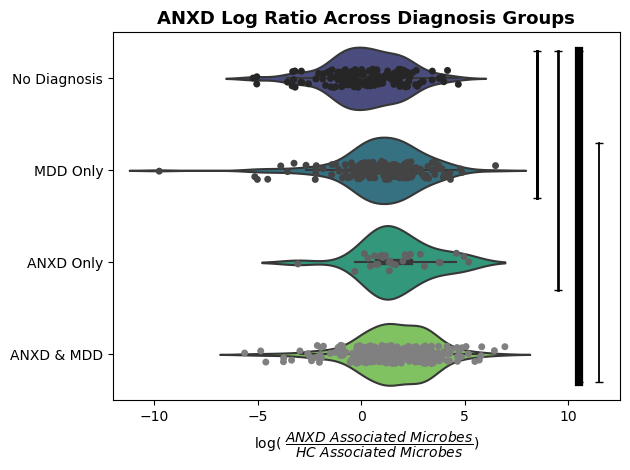

In [18]:
anx_results = get_sig_results(full_metadata, 'diagnosis_group', 'gad_lr')


ax=plt.gca()
sns.violinplot(data=full_metadata, y='diagnosis_group', x='gad_lr', palette='viridis', 
               order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
sns.stripplot(data=full_metadata, y='diagnosis_group', x='gad_lr', hue='diagnosis_group', color='gray', 
              order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], 
              hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('ANXD Log Ratio Across Diagnosis Groups', fontdict={'size':13, 'weight':'heavy'})
ax.set_yticklabels(['No Diagnosis', 'MDD Only', 'ANXD Only', 'ANXD & MDD'])
ax.set_xlim(-12, 12.5)

hc_mdd = anx_results.loc[anx_results['comparison'] == 'HC_vs_MDD_Only'].p_value.values[0]
hc_gad = anx_results.loc[anx_results['comparison'] == 'HC_vs_ANX_Only'].p_value.values[0]
hc_gadmdd = anx_results.loc[anx_results['comparison'] == 'HC_vs_ANX&MDD'].p_value.values[0] 
mdd_gadmdd = anx_results.loc[anx_results['comparison'] == 'ANX&MDD_vs_MDD_Only'].p_value.values[0]

ax.axvline(x=8.5, ymin=0.55, ymax=0.95, color='k', marker='_', lw=-np.log(hc_mdd)/5)
ax.axvline(x=9.5, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gad)/5)
ax.axvline(x=10.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gadmdd)/5)
ax.axvline(x=11.5, ymin=0.05, ymax=0.7, color='k', marker='_', lw=-np.log(mdd_gadmdd)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig2c.png', transparent=True)

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


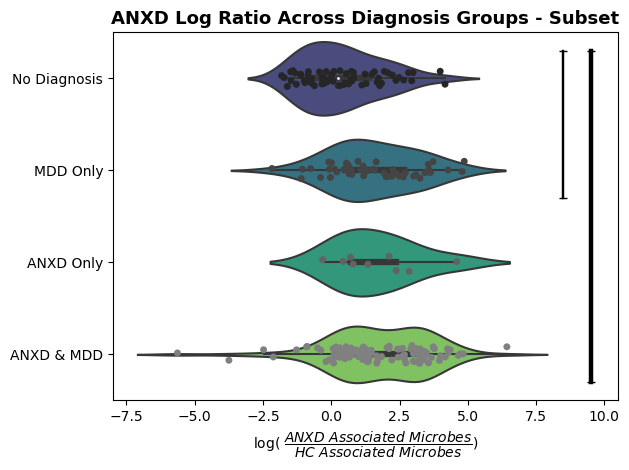

In [19]:
anx_results_subset = get_sig_results(full_metadata, 'diagnosis_group', 'gad_lr', True)

ax=plt.gca()
sns.violinplot(data=metadata_subset, y='diagnosis_group', x='gad_lr', palette='viridis', 
               order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
sns.stripplot(data=metadata_subset, y='diagnosis_group', x='gad_lr', hue='diagnosis_group', color='gray', 
              order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], 
              hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('ANXD Log Ratio Across Diagnosis Groups - Subset', fontdict={'size':13, 'weight':'heavy'})
ax.set_yticklabels(['No Diagnosis', 'MDD Only', 'ANXD Only', 'ANXD & MDD'])
ax.set_xlim(-8, 10.5)

hc_mdd = anx_results_subset.loc[anx_results_subset['comparison'] == 'HC_vs_MDD_Only']['p_value'].values[0]
hc_gadmdd = anx_results_subset.loc[anx_results_subset['comparison'] == 'HC_vs_ANX&MDD']['p_value'].values[0]

ax.axvline(x=8.5, ymin=0.55, ymax=0.95, color='k', marker='_', lw=-np.log(hc_mdd)/5)
ax.axvline(x=9.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gadmdd)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3a.pdf')

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


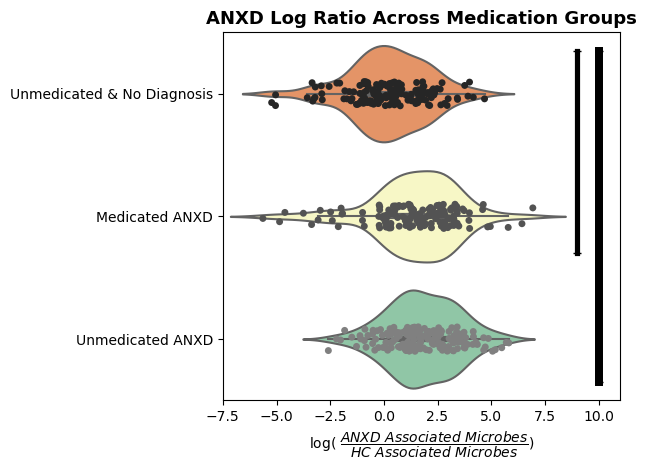

In [22]:
only_valid = full_metadata.loc[full_metadata['gad_med_group'] != 'nan']
anx_med_group = get_sig_results(full_metadata, 'gad_med_group', 'gad_lr')

ax=plt.gca()
sns.violinplot(data=only_valid, y='gad_med_group', x='gad_lr', palette='Spectral', ax=ax)
sns.stripplot(data=only_valid, y='gad_med_group', x='gad_lr', hue='gad_med_group', color='gray', ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('ANXD Log Ratio Across Medication Groups', fontdict={'size':13, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated & No Diagnosis', 'Medicated ANXD', 'Unmedicated ANXD'])
ax.set_xlim(-7.5, 11)

hc_med = anx_med_group.loc[anx_med_group['comparison'] == 'Healthy Controls_vs_Medicated ANX']['p_value']
hc_unmed = anx_med_group.loc[anx_med_group['comparison'] == 'Healthy Controls_vs_Unmedicated ANX']['p_value']
ax.axvline(x=9, ymin=0.4, ymax=0.95, color='k', marker='_', lw=-np.log(hc_med.values[0])/5)
ax.axvline(x=10, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_unmed.values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig2d.pdf')

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


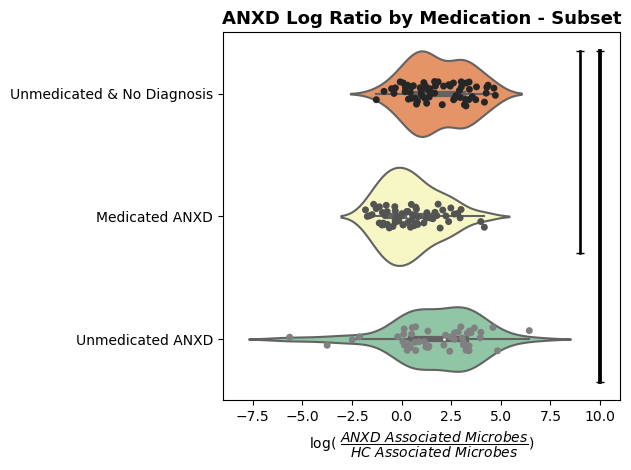

In [23]:
anx_med_group_subset = get_sig_results(metadata_subset, 'gad_med_group', 'gad_lr', True)
hc_med = anx_med_group_subset.loc[anx_med_group_subset['comparison'] == 'Healthy Controls_vs_Medicated ANX']
hc_unmed = anx_med_group_subset.loc[anx_med_group_subset['comparison'] == 'Unmedicated ANX_vs_Healthy Controls']
only_valid = metadata_subset.loc[metadata_subset['gad_med_group'] != 'nan']

ax=plt.gca()
sns.violinplot(data=only_valid, y='gad_med_group', x='gad_lr', palette='Spectral', ax=ax)
sns.stripplot(data=only_valid, y='gad_med_group', x='gad_lr', hue='gad_med_group', color='gray', ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('ANXD Log Ratio by Medication - Subset', fontdict={'size':13, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated & No Diagnosis', 'Medicated ANXD', 'Unmedicated ANXD'])
ax.set_xlim(-9, 11)


ax.axvline(x=9, ymin=0.4, ymax=0.95, color='k', marker='_', lw=-np.log(hc_med['p_value'].values[0])/5)
ax.axvline(x=10, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_unmed['p_value'].values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3c.pdf')

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


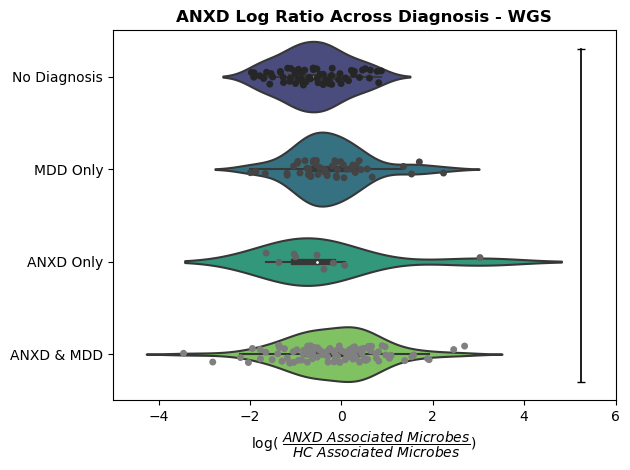

In [24]:
anx_metag_group = get_sig_results(metag_md, 'diagnosis_group', 'gad_lr', metag=True)

ax=plt.gca()
sns.violinplot(data=metag_md, y='diagnosis_group', x='gad_lr', palette='viridis', 
               order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
sns.stripplot(data=metag_md, y='diagnosis_group', x='gad_lr', hue='diagnosis_group', color='gray', 
              order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], 
              hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('ANXD Log Ratio Across Diagnosis - WGS', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['No Diagnosis', 'MDD Only', 'ANXD Only', 'ANXD & MDD'])
ax.set_xlim(-5, 6)

hc_gadmdd = anx_metag_group.loc[anx_metag_group['comparison'] == 'HC_vs_ANX&MDD']['p_value'].values[0]
ax.axvline(x=5.25, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gadmdd)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3b.pdf')

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


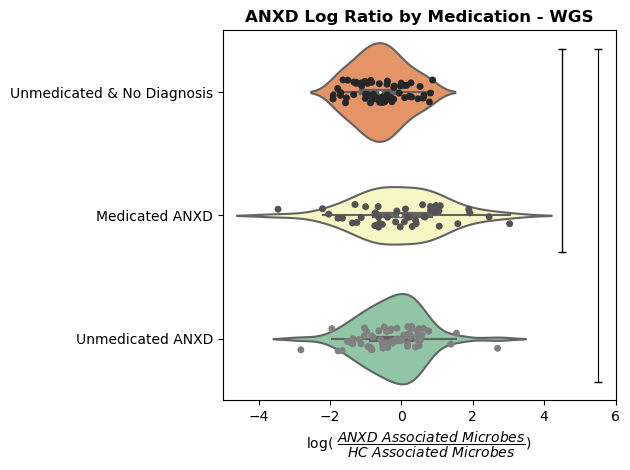

In [25]:
only_valid = metag_md.loc[metag_md['gad_med_group'] != 'nan']
anx_metag_med = get_sig_results(metag_md, 'gad_med_group', 'gad_lr', metag=True)
ax=plt.gca()
sns.violinplot(data=only_valid, y='gad_med_group', x='gad_lr', palette='Spectral', ax=ax)
sns.stripplot(data=only_valid, y='gad_med_group', x='gad_lr', hue='gad_med_group', color='gray', ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('ANXD Log Ratio by Medication - WGS', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated & No Diagnosis', 'Medicated ANXD', 'Unmedicated ANXD'])
ax.set_xlim(-5, 6)

hc_med = anx_metag_med.loc[anx_metag_med['comparison'] == 'Healthy Controls_vs_Medicated ANX']['p_value']
hc_unmed = anx_metag_med.loc[anx_metag_med['comparison'] == 'Healthy Controls_vs_Unmedicated ANX']['p_value']

ax.axvline(x=4.5, ymin=0.4, ymax=0.95, color='k', marker='_', lw=-np.log(hc_med.values[0])/5)
ax.axvline(x=5.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_unmed.values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3d.pdf')

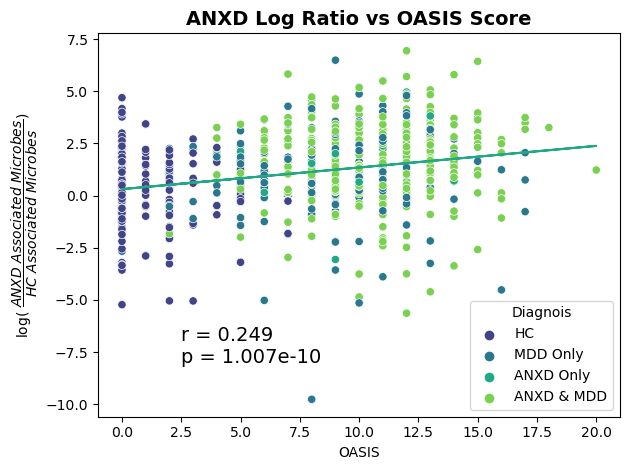

In [38]:
sns.scatterplot(data=full_metadata, y='gad_lr', x='OASIS', palette='viridis', hue='diagnosis_group', 
                hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'])
plt.ylabel(r'log( $\dfrac{ANXD~Associated~Microbes}{HC~Associated~Microbes}$)')
plt.title('ANXD Log Ratio vs OASIS Score', fontdict={'size':14, 'weight': 'bold'})
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles = handles, labels = ['HC', 'MDD Only', 'ANXD Only', 'ANXD & MDD'], title='Diagnois')

subset = full_metadata.loc[(full_metadata['OASIS'].notna()) & (full_metadata['gad_lr'].notna())]
m, b = np.polyfit(subset['OASIS'], subset['gad_lr'], 1)
lr_predicts = m * subset['OASIS'] + b 
plt.plot(subset['OASIS'], lr_predicts, color=(0.134692, 0.658636, 0.517649))

r, p = ss.pearsonr(x=subset['OASIS'].values, y=subset['gad_lr'].values)
plt.text(2.5, -8, 'r = ' + str(np.round(r, 3)) + '\np = ' + str(np.format_float_scientific(p, 3)), fontsize=14)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/anxlr_corr.png', transparent=True)

## Depression Differentials

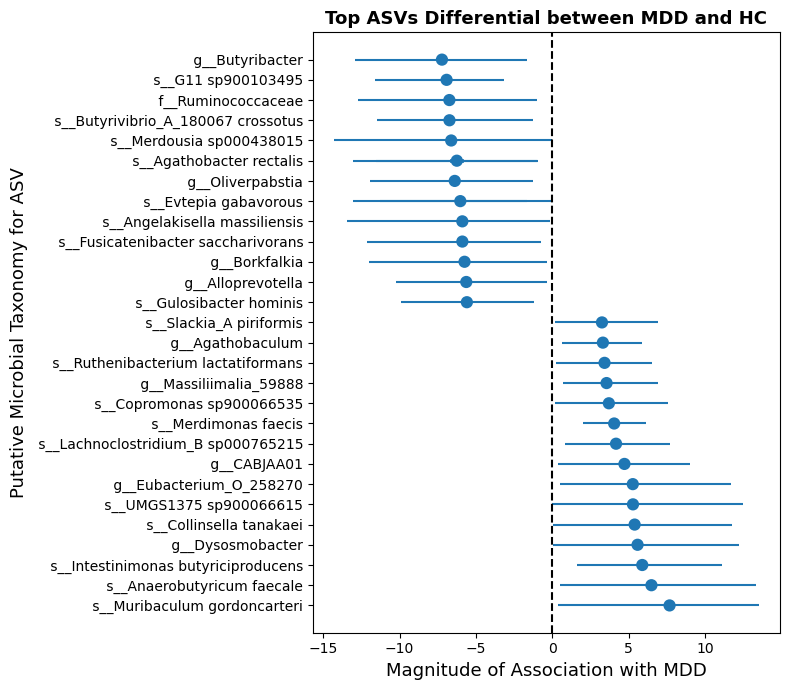

In [39]:
mdd_for_plot = pd.concat([mdd_hc, mdd_enriched]).sort_values(by='DX_MDD[T.True]_mean')
mdd_for_plot = pd.concat([mdd_for_plot[:15], mdd_for_plot[-15:]])
fig, ax = plt.subplots(figsize=(8, 7))
sns.pointplot(data=mdd_for_plot, x='DX_MDD[T.True]_mean', y="taxonomy", join=False, ax=ax)
plt.errorbar(data=mdd_for_plot, x='DX_MDD[T.True]_mean', y="taxonomy",xerr=mdd_for_plot[['lower', 'upper']].T, ls='none')
plt.xlabel('Magnitude of Association with MDD', fontsize=13)
plt.ylabel('Putative Microbial Taxonomy for ASV', fontsize=13)
plt.title('Top ASVs Differential between MDD and HC', fontdict={'size':13, 'weight':'heavy'}) 
plt.axvline(x = 0, color = 'k', linestyle='--')
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig3b.png', transparent=True)

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


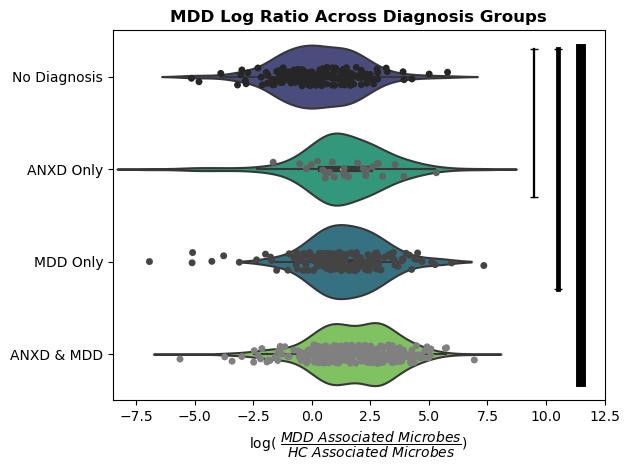

In [59]:
mdd_group = get_sig_results(full_metadata, 'diagnosis_group', 'mdd_lr')
ax=plt.gca()
hc, gad, mdd, both = sns.color_palette(palette='viridis', n_colors=4)
sns.violinplot(data=full_metadata, y='diagnosis_group', x='mdd_lr', palette={'HC': hc, 'ANX_Only': gad, 
                                                                          'MDD_Only': mdd, 'ANX&MDD':both}, 
               order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
sns.stripplot(data=full_metadata, y='diagnosis_group', x='mdd_lr', hue='diagnosis_group', color='gray', 
              order=['HC', 'ANX_Only', 'MDD_Only', 'ANX&MDD'], 
              hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('MDD Log Ratio Across Diagnosis Groups', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['No Diagnosis', 'ANXD Only', 'MDD Only', 'ANXD & MDD'])

ax.set_xlim(-8.5, 12.5)

hc_gad = mdd_group.loc[mdd_group['comparison'] == 'HC_vs_ANX_Only']['p_value'].values[0]
hc_mdd = mdd_group.loc[mdd_group['comparison'] == 'HC_vs_MDD_Only']['p_value'].values[0]
hc_gadmdd = mdd_group.loc[mdd_group['comparison'] == 'HC_vs_ANX&MDD']['p_value'].values[0]

ax.axvline(x=9.5, ymin=0.55, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gad)/5)
ax.axvline(x=10.5, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(hc_mdd)/5)
ax.axvline(x=11.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gadmdd)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig3c.png', transparent=True)

/Users/hazedil/opt/anaconda3/envs/qiime2-2023.5/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


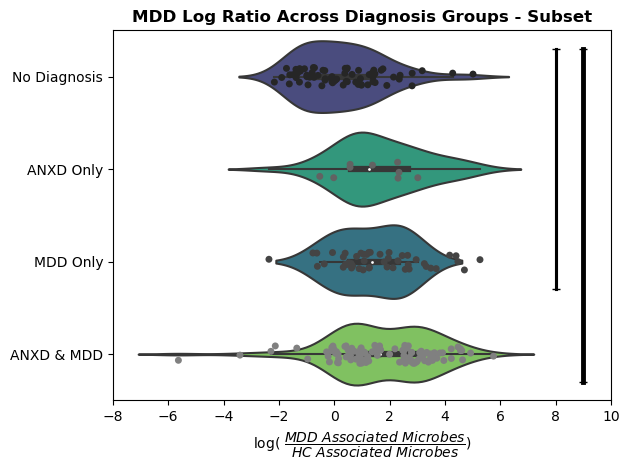

In [41]:
mdd_group_subset = get_sig_results(full_metadata, 'diagnosis_group', 'mdd_lr', True)

ax=plt.gca()
hc, gad, mdd, both = sns.color_palette(palette='viridis', n_colors=4)
sns.violinplot(data=metadata_subset, y='diagnosis_group', x='mdd_lr', palette={'HC': hc, 'ANX_Only': gad, 
                                                                          'MDD_Only': mdd, 'ANX&MDD':both}, 
               order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
sns.stripplot(data=metadata_subset, y='diagnosis_group', x='mdd_lr', hue='diagnosis_group', color='gray', 
              order=['HC', 'ANX_Only', 'MDD_Only', 'ANX&MDD'], 
              hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('MDD Log Ratio Across Diagnosis Groups - Subset', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['No Diagnosis', 'ANXD Only', 'MDD Only', 'ANXD & MDD'])

ax.set_xlim(-8, 10)

hc_mdd = mdd_group_subset.loc[mdd_group_subset['comparison'] == 'HC_vs_MDD_Only']['p_value'].values[0]
hc_gadmdd = mdd_group_subset.loc[mdd_group_subset['comparison'] == 'HC_vs_ANX&MDD']['p_value'].values[0]

ax.axvline(x=8, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(hc_mdd)/5)
ax.axvline(x=9, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gadmdd)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3e.pdf')

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


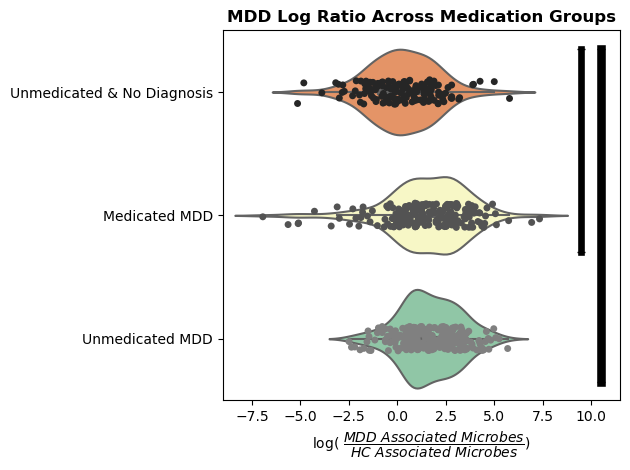

In [34]:
only_valid = full_metadata.loc[full_metadata['mdd_med_group'] != 'nan']
mdd_med_group = get_sig_results(full_metadata, 'mdd_med_group', 'mdd_lr')

ax=plt.gca()
sns.violinplot(data=only_valid, y='mdd_med_group', x='mdd_lr', palette='Spectral', ax=ax)
sns.stripplot(data=only_valid, y='mdd_med_group', x='mdd_lr', hue='mdd_med_group', color='gray', ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('MDD Log Ratio Across Medication Groups', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated & No Diagnosis', 'Medicated MDD', 'Unmedicated MDD'])
ax.set_xlim(-9, 11.5)

hc_med = mdd_med_group.loc[mdd_med_group['comparison'] == 'Healthy Controls_vs_Medicated MDD']['p_value']
hc_unmed = mdd_med_group.loc[mdd_med_group['comparison'] == 'Healthy Controls_vs_Unmedicated MDD']['p_value']

ax.axvline(x=9.5, ymin=0.4, ymax=0.95, color='k', marker='_', lw=-np.log(hc_med.values[0])/5)
ax.axvline(x=10.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_unmed.values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig3d.pdf')

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


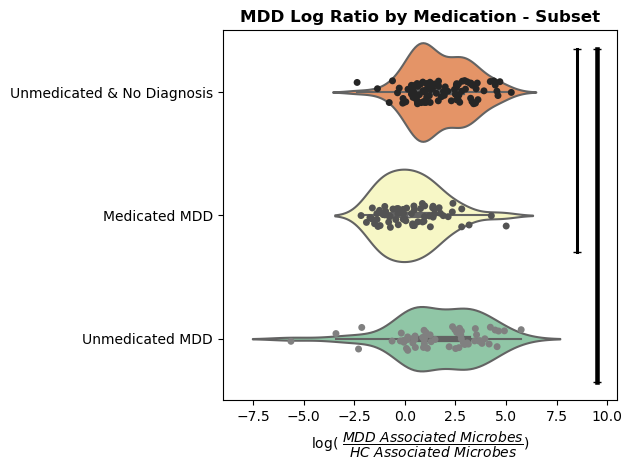

In [35]:
only_valid = metadata_subset.loc[metadata_subset['mdd_med_group'] != 'nan']
mdd_med_subset = get_sig_results(full_metadata, 'mdd_med_group', 'mdd_lr', True)

ax=plt.gca()
sns.violinplot(data=only_valid, y='mdd_med_group', x='mdd_lr', palette='Spectral', ax=ax)
sns.stripplot(data=only_valid, y='mdd_med_group', x='mdd_lr', hue='mdd_med_group', color='gray', ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('MDD Log Ratio by Medication - Subset', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated & No Diagnosis', 'Medicated MDD', 'Unmedicated MDD'])
ax.set_xlim(-9, 10.5)

hc_med = mdd_med_subset.loc[mdd_med_subset['comparison'] == 'Healthy Controls_vs_Medicated MDD']['p_value']
hc_unmed = mdd_med_subset.loc[mdd_med_subset['comparison'] == 'Healthy Controls_vs_Unmedicated MDD']['p_value']

ax.axvline(x=8.5, ymin=0.4, ymax=0.95, color='k', marker='_', lw=-np.log(hc_med.values[0])/5)
ax.axvline(x=9.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_unmed.values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3g.pdf')

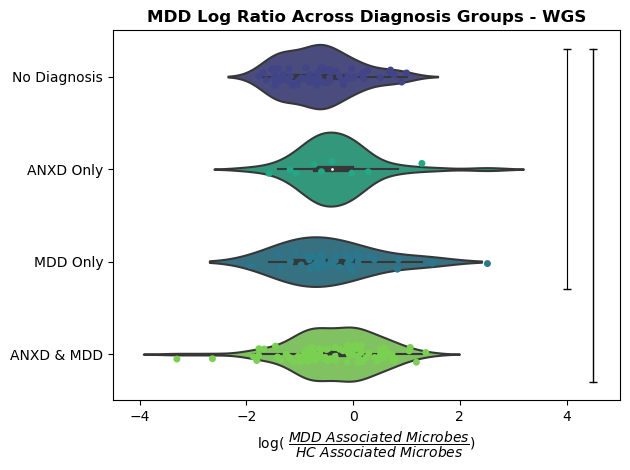

In [42]:
mdd_metag = get_sig_results(metag_md, 'diagnosis_group', 'mdd_lr', metag=True)
ax=plt.gca()
hc, gad, mdd, both = sns.color_palette(palette='viridis', n_colors=4)
sns.violinplot(data=metag_md, y='diagnosis_group', x='mdd_lr', palette={'HC': hc, 'ANX_Only': gad, 
                                                                          'MDD_Only': mdd, 'ANX&MDD':both}, 
               order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
sns.stripplot(data=metag_md, y='diagnosis_group', x='mdd_lr', hue='diagnosis_group', palette='viridis', 
              order=['HC', 'ANX_Only', 'MDD_Only', 'ANX&MDD'], 
              hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('MDD Log Ratio Across Diagnosis Groups - WGS', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['No Diagnosis', 'ANXD Only', 'MDD Only', 'ANXD & MDD'])
ax.set_xlim(-4.5, 5)

hc_mdd = mdd_metag.loc[mdd_metag['comparison'] == 'HC_vs_MDD_Only']['p_value'].values[0]
hc_gadmdd = mdd_metag.loc[mdd_metag['comparison'] == 'HC_vs_ANX&MDD']['p_value'].values[0]

ax.axvline(x=4, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(hc_mdd)/5)
ax.axvline(x=4.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gadmdd)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3f.pdf')

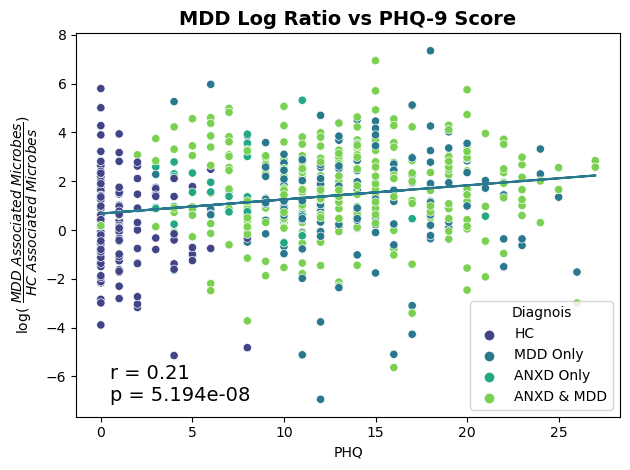

In [43]:
sns.scatterplot(data=full_metadata, y='mdd_lr', x='PHQ', palette='viridis', hue='diagnosis_group', 
                hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'])
plt.ylabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
plt.title('MDD Log Ratio vs PHQ-9 Score', fontdict={'size':14, 'weight': 'bold'})
plt.legend(handles = handles, labels = ['HC', 'MDD Only', 'ANXD Only', 'ANXD & MDD'], title='Diagnois')

subset = full_metadata.loc[(full_metadata['PHQ'].notna()) & (full_metadata['mdd_lr'].notna())]
m, b = np.polyfit(subset['PHQ'], subset['mdd_lr'], 1)
lr_predicts = m * subset['PHQ'] + b 
plt.plot(subset['PHQ'], lr_predicts, color=(0.163625, 0.471133, 0.558148))

r, p = ss.pearsonr(x=subset['PHQ'].values, y=subset['mdd_lr'].values)
plt.text(0.5, -7, 'r = ' + str(np.round(r, 3)) + '\np = ' + str(np.format_float_scientific(p, 3)), fontsize=14)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/deplr_corr.png', transparent=True)

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)


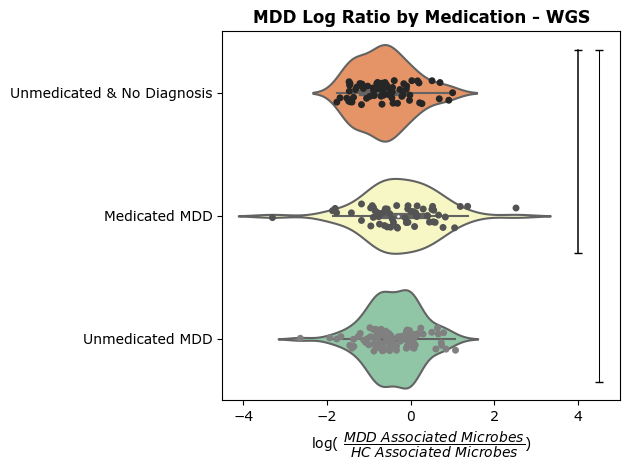

In [48]:
only_valid = metag_md.loc[metag_md['mdd_med_group'] != 'nan']
mdd_med_metag = get_sig_results(only_valid, 'mdd_med_group', 'mdd_lr', metag=True)

ax=plt.gca()
sns.violinplot(data=only_valid, y='mdd_med_group', x='mdd_lr', palette='Spectral', ax=ax)
sns.stripplot(data=only_valid, y='mdd_med_group', x='mdd_lr', hue='mdd_med_group', color='gray', ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('MDD Log Ratio by Medication - WGS', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated & No Diagnosis', 'Medicated MDD', 'Unmedicated MDD'])
ax.set_xlim(-4.5, 5)

hc_med = mdd_med_metag.loc[mdd_med_metag['comparison'] == 'Healthy Controls_vs_Medicated MDD']['p_value']
hc_unmed = mdd_med_metag.loc[mdd_med_metag['comparison'] == 'Healthy Controls_vs_Unmedicated MDD']['p_value']

ax.axvline(x=4, ymin=0.4, ymax=0.95, color='k', marker='_', lw=-np.log(hc_med.values[0])/5)
ax.axvline(x=4.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_unmed.values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs3h.pdf')

## American Gut Validation for Depression

See Barnacle because I had to run it there

## Overlaps between GAD- and MDD- associated microbes

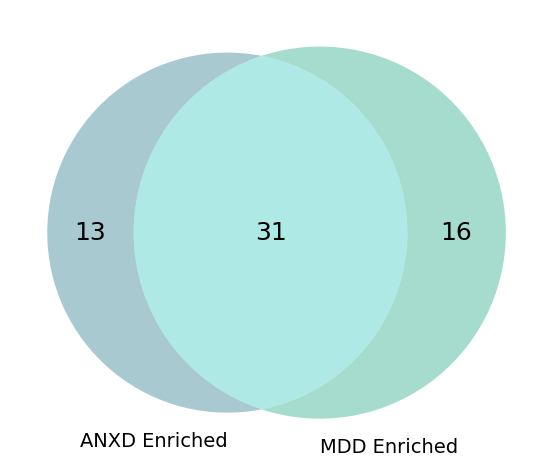

In [44]:
out = venn2(subsets=[set(anx_enriched.index), set(mdd_enriched.index)], 
            set_labels=('ANXD Enriched', 'MDD Enriched'), set_colors=(gad, mdd))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs1a.png', transparent=True)

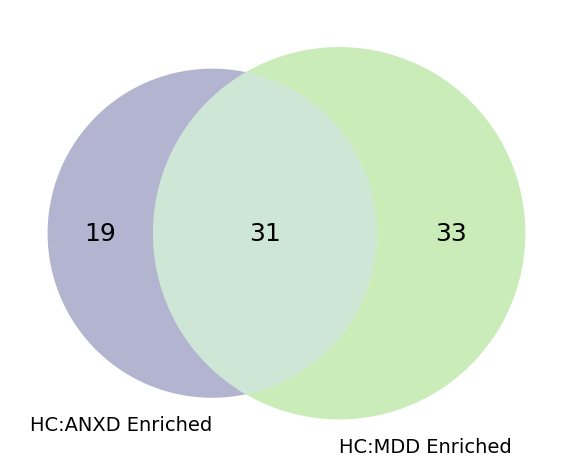

In [45]:
out = venn2(subsets=[set(anx_hc.index), set(mdd_hc.index)], set_labels=('HC:ANXD Enriched', 'HC:MDD Enriched'), 
      set_colors=(hc, both))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs1b.pdf')

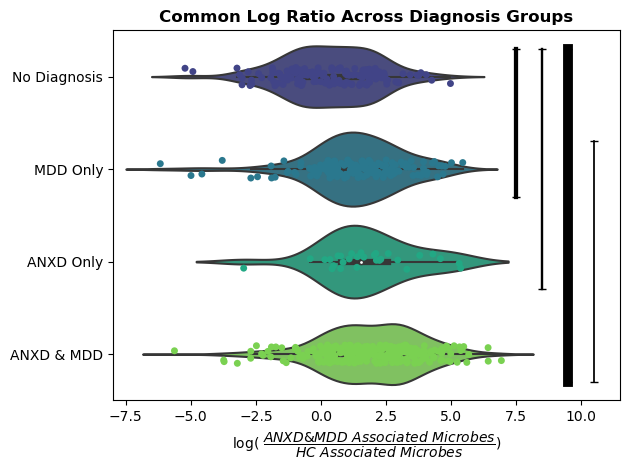

In [46]:
common_group = get_sig_results(full_metadata, 'diagnosis_group', 'common_lr')
ax=plt.gca()
sns.violinplot(data=full_metadata, y='diagnosis_group', x='common_lr', palette='viridis', 
               order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
sns.stripplot(data=full_metadata, y='diagnosis_group', x='common_lr', hue='diagnosis_group', palette='viridis', 
              order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], 
              hue_order=['HC', 'MDD_Only', 'ANX_Only', 'ANX&MDD'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD&MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('Common Log Ratio Across Diagnosis Groups', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['No Diagnosis', 'MDD Only', 'ANXD Only', 'ANXD & MDD'])
ax.set_xlim(-8, 11.5)

hc_mdd = common_group.loc[common_group['comparison'] == 'HC_vs_MDD_Only']['p_value'].values[0]
hc_gad = common_group.loc[common_group['comparison'] == 'HC_vs_ANX_Only']['p_value'].values[0]
hc_gadmdd = common_group.loc[common_group['comparison'] == 'HC_vs_ANX&MDD']['p_value'].values[0]
mdd_gadmdd = common_group.loc[common_group['comparison'] == 'ANX&MDD_vs_MDD_Only']['p_value'].values[0]

ax.axvline(x=7.5, ymin=0.55, ymax=0.95, color='k', marker='_', lw=-np.log(hc_mdd)/5)
ax.axvline(x=8.5, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gad)/5)
ax.axvline(x=9.5, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_gadmdd)/5)
ax.axvline(x=10.5, ymin=0.05, ymax=0.7, color='k', marker='_', lw=-np.log(mdd_gadmdd)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs1e.pdf')

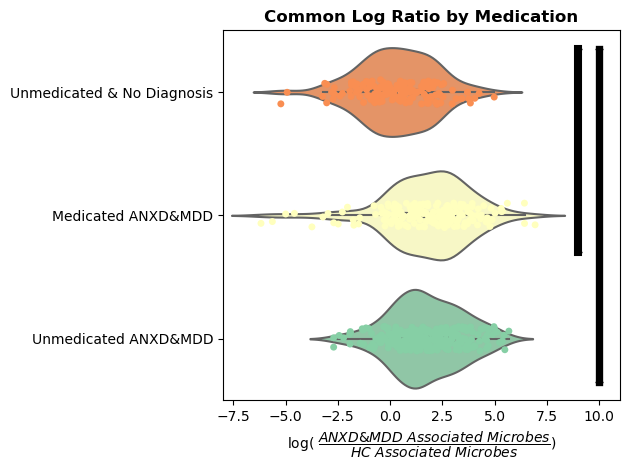

In [47]:
only_valid = full_metadata.loc[full_metadata['common_group'] != 'nan']
common_med = get_sig_results(only_valid, 'common_group', 'common_lr')
ax=plt.gca()
sns.violinplot(data=only_valid, y='common_group', x='common_lr', palette='Spectral', ax=ax)
sns.stripplot(data=only_valid, y='common_group', x='common_lr', hue='common_group', palette='Spectral', ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{ANXD&MDD~Associated~Microbes}{HC~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('Common Log Ratio by Medication', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated & No Diagnosis', 'Medicated ANXD&MDD', 'Unmedicated ANXD&MDD'])
ax.set_xlim(-8, 11)

hc_med = common_med.loc[common_med['comparison'] == 'Healthy Controls_vs_Medicated Mood/Anxiety']['p_value']
hc_unmed = common_med.loc[common_med['comparison'] == 'Healthy Controls_vs_Unmedicated Mood/Anxiety']['p_value']

ax.axvline(x=9, ymin=0.4, ymax=0.95, color='k', marker='_', lw=-np.log(hc_med.values[0])/5)
ax.axvline(x=10, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(hc_unmed.values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs1f.pdf')

In [48]:
anxiolytics_enriched = all_results['Medications_Anxiety'].loc[all_results['Medications_Anxiety']['direction'] == 'Anxiolytics']
no_med_anx = all_results['Medications_Anxiety'].loc[all_results['Medications_Anxiety']['direction'] == 'Unmedicated ANX']
antidepressants_enriched = all_results['Medications_Depression'].loc[all_results['Medications_Depression']['direction'] == 'Antidepressants']
no_med_mdd = all_results['Medications_Depression'].loc[all_results['Medications_Depression']['direction'] == 'Unmedicated MDD']

med_enriched = anxiolytics_enriched.index.intersection(antidepressants_enriched.index)
no_med = no_med_anx.index.intersection(no_med_mdd.index)

In [49]:
anxiolytics_enriched.to_csv('../Updated_Results/birdman_sig_plots/anxiolytics_enriched.csv')
no_med_anx.to_csv('../Updated_Results/birdman_sig_plots/no_med_anx.csv')

antidepressants_enriched.to_csv('../Updated_Results/birdman_sig_plots/antidepressants_enriched.csv')
no_med_mdd.to_csv('../Updated_Results/birdman_sig_plots/no_med_mdd.csv')

## Anxiolytics Differentials

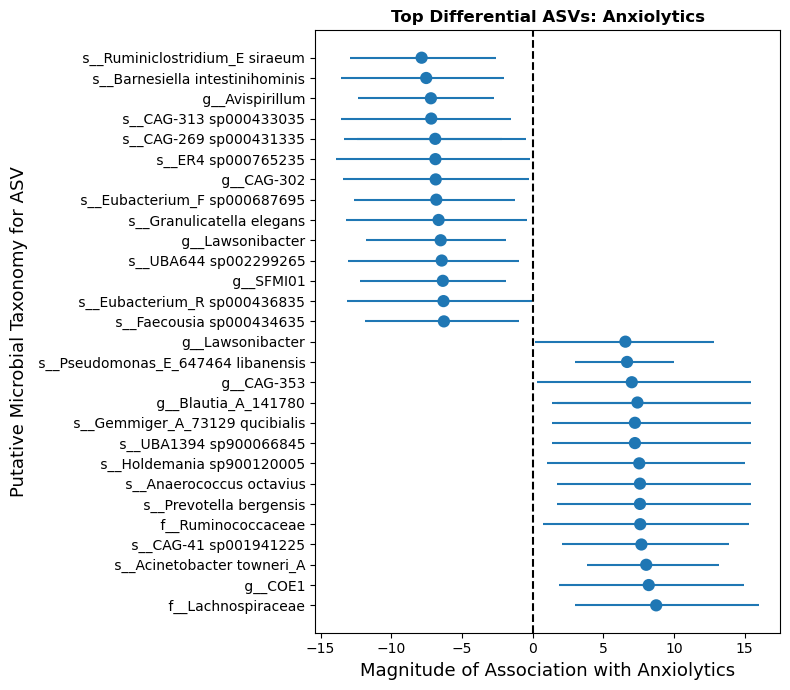

In [65]:
anxio_for_plot = pd.concat([no_med_anx, anxiolytics_enriched]).sort_values(by='N05B_Anxiolytics[T.True]_mean')
# make distinct entries for g__Lawsonibacter
anxio_for_plot['taxonomy'] = np.where((anxio_for_plot['taxonomy'] == ' g__Lawsonibacter') & 
                                      (anxio_for_plot['direction'] == 'Anxiolytics'), 'g__Lawsonibacter', 
                                      anxio_for_plot['taxonomy'])
anxio_for_plot = pd.concat([anxio_for_plot[:15], anxio_for_plot[-15:]])
fig, ax = plt.subplots(figsize=(8, 7))
sns.pointplot(data=anxio_for_plot, x='N05B_Anxiolytics[T.True]_mean', y="taxonomy", join=False, ax=ax)
plt.errorbar(data=anxio_for_plot, x='N05B_Anxiolytics[T.True]_mean', y="taxonomy",
             xerr=anxio_for_plot[['lower', 'upper']].T, ls='none')
plt.xlabel('Magnitude of Association with Anxiolytics', fontsize=13)
plt.ylabel('Putative Microbial Taxonomy for ASV', fontsize=13)
plt.title('Top Differential ASVs: Anxiolytics', fontdict={'size':12, 'weight':'heavy'}) 
plt.axvline(x = 0, color = 'k', linestyle='--')
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig4b.png', transparent=True)

In [55]:
full_metadata['medication_category'] = np.where((full_metadata['medication_anxiolytics']=='Anxiolytics') & 
                                                (full_metadata['medication_antidepressants']=='Antidepressants'), 
                                                'Anxiolytics&Antidepressants',
                                                np.where(full_metadata['medication_anxiolytics']=='Anxiolytics', 
                                                         'Anxiolytics', 
                                                         np.where(full_metadata['medication_antidepressants'] == 'Antidepressants', 
                                                                  'Antidepressants',
                                                                  np.where((full_metadata['medication_group']=='Unmedicated') & (full_metadata['GroupAssignment'] == 'Mood/Anxiety'), 
                                                                           'Unmedicated', 'Other'))))
med_metadata = full_metadata.loc[full_metadata['medication_category']!='Other']
med_metadata['anxiolytic_lr'] = full_table_df.apply(create_log_ratio_column, axis=1, 
                                                    args=(anxiolytics_enriched.index, no_med_anx.index))
med_metadata['antidepressant_lr'] = full_table_df.apply(create_log_ratio_column, axis=1, 
                                                        args=(antidepressants_enriched.index, no_med_mdd.index))
med_metadata['double_med_lr'] = full_table_df.apply(create_log_ratio_column, axis=1, 
                                                    args=(med_enriched, no_med))

/var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/ipykernel_59912/2462619516.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_metadata['anxiolytic_lr'] = full_table_df.apply(create_log_ratio_column, axis=1,
/var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/ipykernel_59912/2462619516.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  med_metadata['antidepressant_lr'] = full_table_df.apply(create_log_ratio_column, axis=1,
/var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/ipykernel_59912/2462619516.py:1

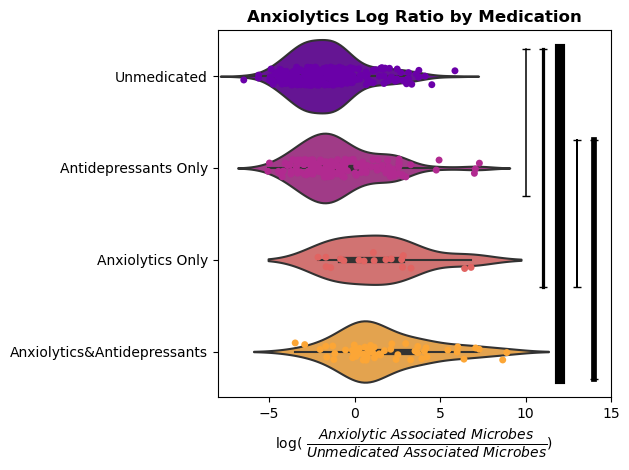

In [60]:
anx_med = get_sig_results(med_metadata, 'medication_category', 'anxiolytic_lr')
ax=plt.gca()
sns.violinplot(data=med_metadata, y='medication_category', x='anxiolytic_lr', palette='plasma', 
               order=['Unmedicated', 'Antidepressants', 'Anxiolytics', 'Anxiolytics&Antidepressants'], ax=ax)
sns.stripplot(data=med_metadata, y='medication_category', x='anxiolytic_lr', hue='medication_category', 
              palette='plasma', 
              order=['Unmedicated', 'Antidepressants', 'Anxiolytics', 'Anxiolytics&Antidepressants'], 
              hue_order=['Unmedicated', 'Antidepressants', 'Anxiolytics', 'Anxiolytics&Antidepressants'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{Anxiolytic~Associated~Microbes}{Unmedicated~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('Anxiolytics Log Ratio by Medication', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated', 'Antidepressants Only', 'Anxiolytics Only', 'Anxiolytics&Antidepressants'])
ax.set_xlim(-8, 15)

both_med = 'Anxiolytics&Antidepressants'
um_dep = anx_med.loc[anx_med['comparison'] == 'Antidepressants_vs_Unmedicated']['p_value']
um_anx = anx_med.loc[anx_med['comparison'] == 'Anxiolytics_vs_Unmedicated']['p_value']
um_anxdep = anx_med.loc[anx_med['comparison'] == both_med+'_vs_Unmedicated']['p_value']
anx_dep = anx_med.loc[anx_med['comparison'] == 'Antidepressants_vs_Anxiolytics']['p_value']
dep_anxdep = anx_med.loc[anx_med['comparison'] == 'Antidepressants_vs_' + both_med]['p_value']


ax.axvline(x=10, ymin=0.55, ymax=0.95, color='k', marker='_', lw=-np.log(um_dep.values[0])/5)
ax.axvline(x=11, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(um_anx.values[0])/5)
ax.axvline(x=12, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(um_anxdep.values[0])/5)
ax.axvline(x=13, ymin=0.3, ymax=0.7, color='k', marker='_', lw=-np.log(anx_dep.values[0])/5)
ax.axvline(x=14, ymin=0.05, ymax=0.7, color='k', marker='_', lw=-np.log(dep_anxdep.values[0])/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig4e.png', transparent=True)

## Antidepressant Differentials

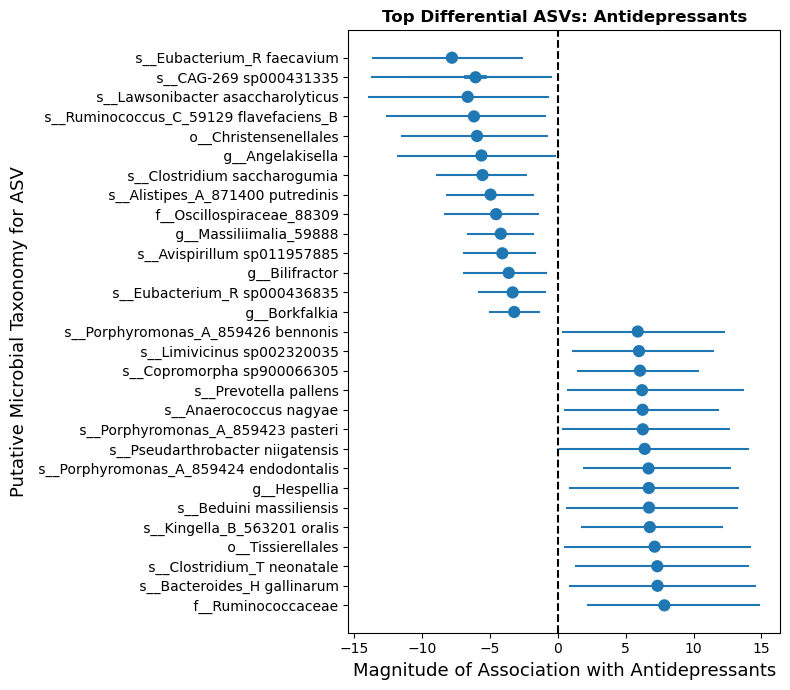

In [61]:
antidep_for_plot = pd.concat([no_med_mdd, antidepressants_enriched]).sort_values(by='N06A_Antidepressants[T.True]_mean')
antidep_for_plot = pd.concat([antidep_for_plot[:15], antidep_for_plot[-15:]])
fig, ax = plt.subplots(figsize=(8, 7))
sns.pointplot(data=antidep_for_plot, x='N06A_Antidepressants[T.True]_mean', y="taxonomy", join=False, ax=ax)
plt.errorbar(data=antidep_for_plot, x='N06A_Antidepressants[T.True]_mean', y="taxonomy",
             xerr=antidep_for_plot[['lower', 'upper']].T, ls='none')
plt.xlabel('Magnitude of Association with Antidepressants', fontsize=13)
plt.ylabel('Putative Microbial Taxonomy for ASV', fontsize=13)
plt.title('Top Differential ASVs: Antidepressants', fontdict={'size':12, 'weight':'heavy'}) 
plt.axvline(x = 0, color = 'k', linestyle='--')
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig4c.png', transparent=True)

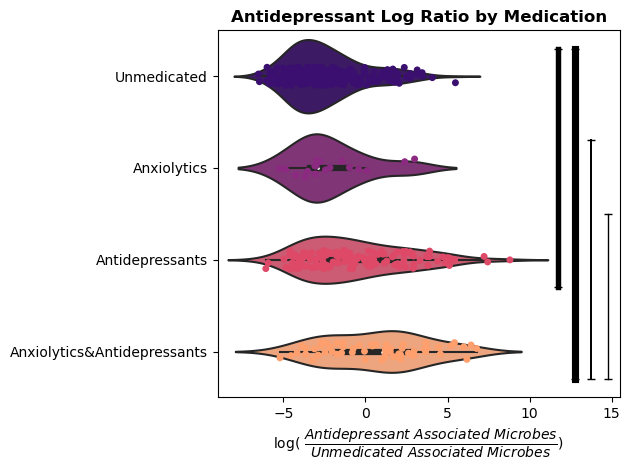

In [62]:
anti_med = get_sig_results(med_metadata, 'medication_category', 'antidepressant_lr')

ax=plt.gca()
sns.violinplot(data=med_metadata, y='medication_category', x='antidepressant_lr', palette='magma', 
               order=['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'], ax=ax)
sns.stripplot(data=med_metadata, y='medication_category', x='antidepressant_lr', hue='medication_category', 
              palette='magma', 
              order=['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'], 
              hue_order=['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{Antidepressant~Associated~Microbes}{Unmedicated~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('Antidepressant Log Ratio by Medication', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'])
ax.set_xlim(-9, 15.5)

um_dep = anti_med.loc[anti_med['comparison'] == 'Antidepressants_vs_Unmedicated']['p_value'].values[0]
um_anxdep = anti_med.loc[anti_med['comparison'] == both_med + '_vs_Unmedicated']['p_value'].values[0]
anx_anxdep = anti_med.loc[anti_med['comparison'] == both_med + '_vs_Anxiolytics']['p_value'].values[0]
dep_anxdep = anti_med.loc[anti_med['comparison'] == 'Antidepressants_vs_' + both_med]['p_value'].values[0]


ax.axvline(x=11.75, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(um_dep)/5)
ax.axvline(x=12.75, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(um_anxdep)/5)
ax.axvline(x=13.75, ymin=0.05, ymax=0.7, color='k', marker='_', lw=-np.log(anx_anxdep)/5)
ax.axvline(x=14.75, ymin=0.05, ymax=0.5, color='k', marker='_', lw=-np.log(dep_anxdep)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/fig4f.png', transparent=True)

## Overlap between Anxiolytics & Antidepressants

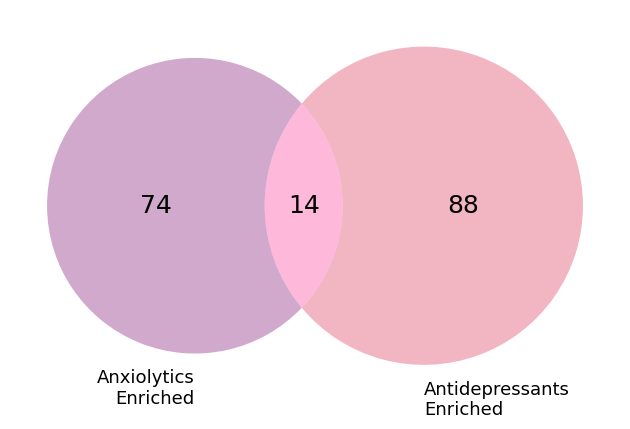

In [63]:
um, anx, dep, anx_dep = sns.color_palette(palette='magma', n_colors=4)
out = venn2(subsets=[set(anxiolytics_enriched.index), set(antidepressants_enriched.index)], 
            set_labels=('Anxiolytics\nEnriched', 'Antidepressants\nEnriched'), 
            set_colors=(anx, dep))
for txt in out.set_labels:
   txt.set_fontsize(13)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs1c.png', transparent=True)

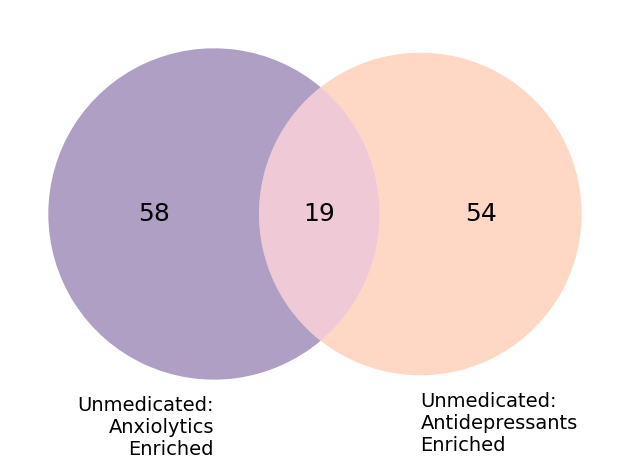

In [64]:
out = venn2(subsets=[set(no_med_anx.index), set(no_med_mdd.index)], 
      set_labels=('Unmedicated:\nAnxiolytics\nEnriched', 'Unmedicated:\nAntidepressants\nEnriched'), 
      set_colors=(um, anx_dep))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs1d.pdf')

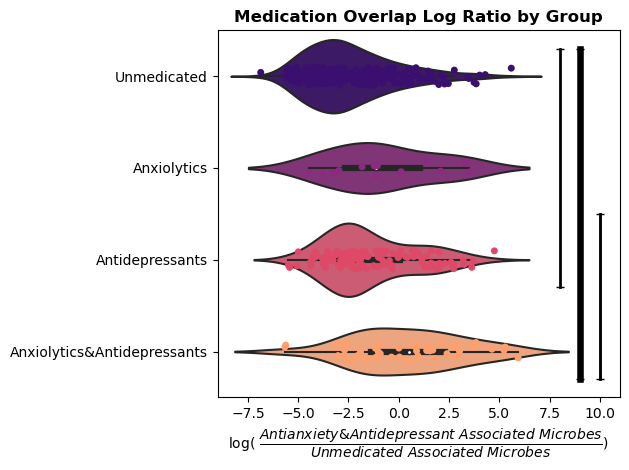

In [65]:
double_med = get_sig_results(med_metadata, 'medication_category', 'double_med_lr')

ax=plt.gca()
sns.violinplot(data=med_metadata, y='medication_category', x='double_med_lr', palette='magma', 
               order=['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'], ax=ax)
sns.stripplot(data=med_metadata, y='medication_category', x='double_med_lr', hue='medication_category', 
              palette='magma', 
              order=['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'], 
              hue_order=['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'], ax=ax)
plt.legend([],[], frameon=False)
ax.set_xlabel(r'log( $\dfrac{Antianxiety&Antidepressant~Associated~Microbes}{Unmedicated~Associated~Microbes}$)')
ax.set_ylabel('')
ax.set_title('Medication Overlap Log Ratio by Group', fontdict={'size':12, 'weight':'heavy'})
ax.set_yticklabels(['Unmedicated', 'Anxiolytics', 'Antidepressants', 'Anxiolytics&Antidepressants'])
ax.set_xlim(-9, 11)

um_dep = double_med.loc[double_med['comparison'] == 'Antidepressants_vs_Unmedicated']['p_value'].values[0]
um_anxdep = double_med.loc[double_med['comparison'] == both_med+'_vs_Unmedicated']['p_value'].values[0]
dep_anxdep = double_med.loc[double_med['comparison'] == 'Antidepressants_vs_'+both_med]['p_value'].values[0]

ax.axvline(x=8, ymin=0.3, ymax=0.95, color='k', marker='_', lw=-np.log(um_dep)/5)
ax.axvline(x=9, ymin=0.05, ymax=0.95, color='k', marker='_', lw=-np.log(um_anxdep)/5)
ax.axvline(x=10, ymin=0.05, ymax=0.5, color='k', marker='_', lw=-np.log(dep_anxdep)/5)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs1g.pdf')

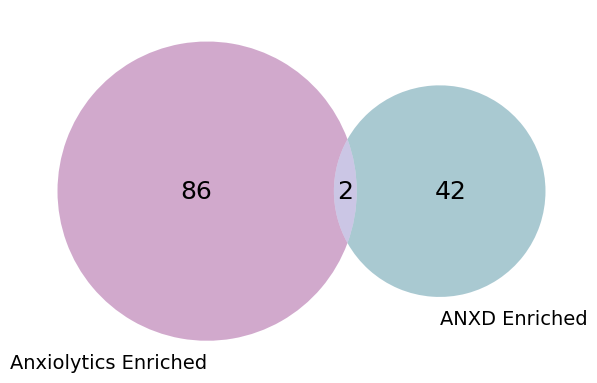

In [66]:
out = venn2(subsets=[set(anxiolytics_enriched.index), set(anx_enriched.index)], 
      set_labels=('Anxiolytics Enriched', 'ANXD Enriched'), 
      set_colors=(anx, gad))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2a.pdf')

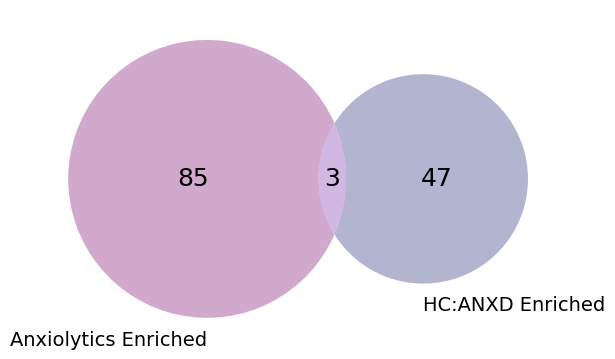

In [67]:
out = venn2(subsets=[set(anxiolytics_enriched.index), set(anx_hc.index)], 
      set_labels=('Anxiolytics Enriched', 'HC:ANXD Enriched'), 
      set_colors=(anx, hc))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2b.pdf')

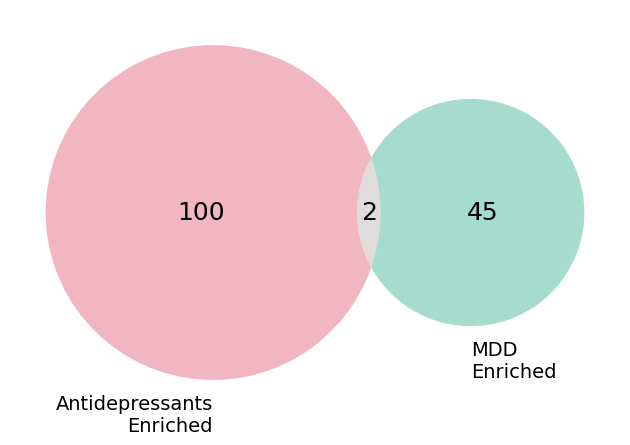

In [68]:
out = venn2(subsets=[set(antidepressants_enriched.index), set(mdd_enriched.index)], 
      set_labels=('Antidepressants\nEnriched', 'MDD\nEnriched'), 
      set_colors=(dep, mdd))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2c.pdf')

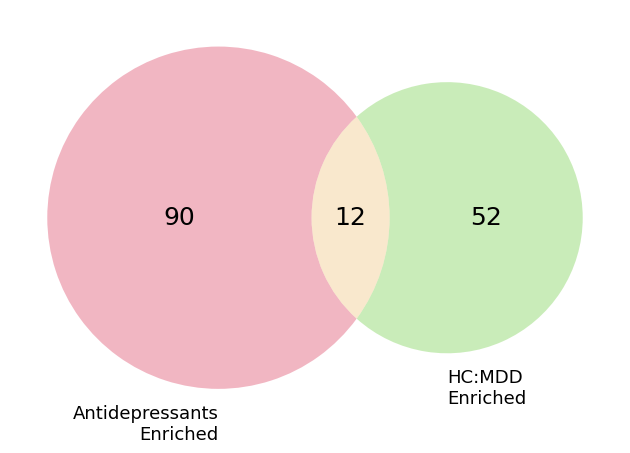

In [69]:
out = venn2(subsets=[set(antidepressants_enriched.index), set(mdd_hc.index)], 
            set_labels=('Antidepressants\nEnriched', 'HC:MDD\nEnriched'), 
            set_colors=(dep, both))
for txt in out.set_labels:
   txt.set_fontsize(13)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2d.png', transparent=True)

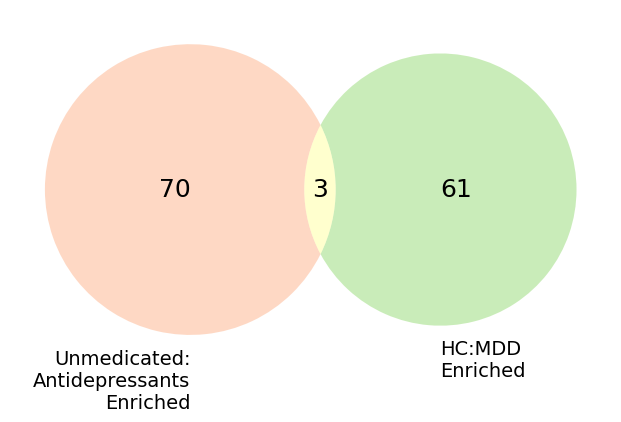

In [70]:
out = venn2(subsets=[set(no_med_mdd.index), set(mdd_hc.index)], 
      set_labels=('Unmedicated:\nAntidepressants\nEnriched', 'HC:MDD\nEnriched'), 
      set_colors=(anx_dep, both))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2f.pdf')

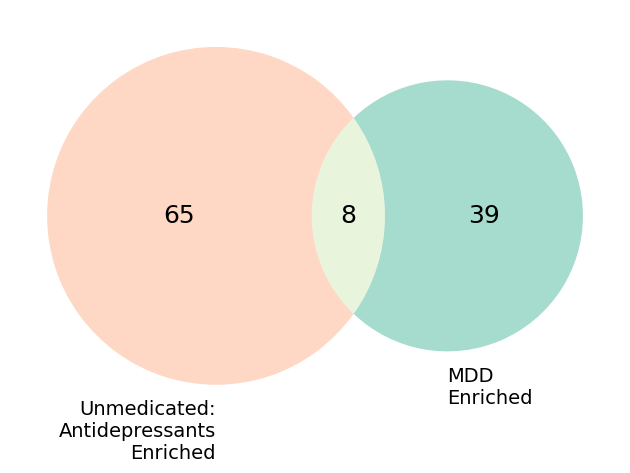

In [71]:
out = venn2(subsets=[set(no_med_mdd.index), set(mdd_enriched.index)], 
      set_labels=('Unmedicated:\nAntidepressants\nEnriched', 'MDD\nEnriched'), 
      set_colors=(anx_dep, mdd))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2h.pdf')

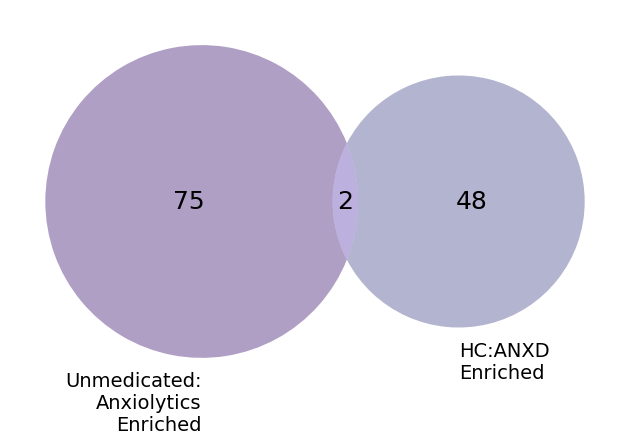

In [72]:
out = venn2(subsets=[set(no_med_anx.index), set(anx_hc.index)], 
      set_labels=('Unmedicated:\nAnxiolytics\nEnriched', 'HC:ANXD\nEnriched'), 
      set_colors=(um, hc))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2e.pdf')

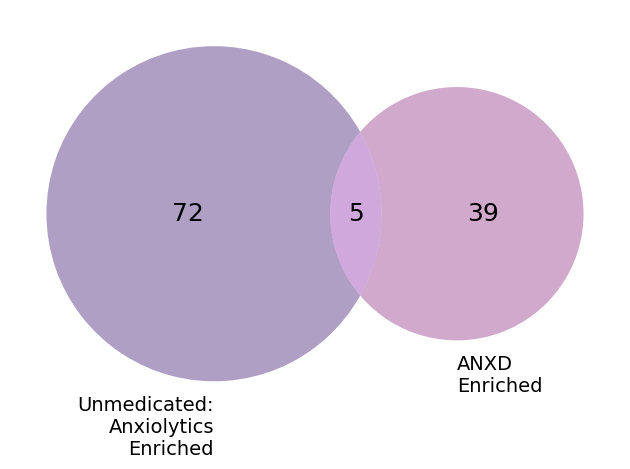

In [73]:
out = venn2(subsets=[set(no_med_anx.index), set(anx_enriched.index)], 
      set_labels=('Unmedicated:\nAnxiolytics\nEnriched', 'ANXD\nEnriched'), 
      set_colors=(um, anx))
for txt in out.set_labels:
   txt.set_fontsize(14)
for txt in out.subset_labels:
   txt.set_fontsize(18)
plt.tight_layout()
plt.savefig('../Updated_Results/Figures/figs2g.pdf')

In [249]:
significances_lr = pd.concat([anx_results, anx_results_subset, anx_med_group, anx_med_group_subset, 
                              anx_metag_group, anx_metag_med, mdd_group, mdd_group_subset, mdd_med_group,
                              mdd_med_subset, mdd_metag, mdd_med_metag, common_group, common_med, anx_med, 
                              anti_med, double_med])
significances_lr.reset_index(drop=True, inplace=True)
significances_lr.to_csv('../Updated_Results/tables2_lr_significances.tsv', sep='\t')